# Enriching Water and Power Usage Data for the city of Los Angeles, California

### M. J. Madsen

This notebook walks through enriching the LA Utility data.

In [31]:
## Library Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.covariance import EmpiricalCovariance

from time import time
import seaborn as sns
%matplotlib inline
sns.set_style("white")

# Preliminary Data Exploration

I am using data from the city of Los Angeles originally found from this website.

> https://data.lacity.org/A-Livable-and-Sustainable-City/Water-and-Electric-Usage-from-2005-2013/asvq-scwp

The dataset has four columns of interest:
1. The month in which the data was recorded
2. The zip code (geographical location) for the data
3. The water use for that zip code (measured in HCF)
4. The power use for that zip code (measure in kWh)

The raw data has another column (Value Date) that we will not be using. I first examine the raw data.

In [2]:
dfv1 = pd.read_csv("../data/Water_and_Electric_Usage_from_2005_-_2013.csv")
dfv1.head(2)

,Text Date,Value Date,Zip Code,Water Use,Power Use
0,Mar_2008,Mar-08,"90230\n(33.99506171100046, -118.39500957899969)",16.70,396
1,Jul_2011,Jul-11,"90272\n(34.04886156900045, -118.53572692799969)",35.73,1013


Before moving forward, there are some obvious data cleaning steps that need to be taken. I change the date from text to a datetime object and extract the 5-digit zip code from the Zip Code column. Finally, I drop the unneeded columns from the dataframe.

In [3]:
dfv1['Date'] = pd.to_datetime(dfv1["Text Date"], format="%b_%Y")
dfv1['Zip'] = dfv1['Zip Code'].str.extract("(.*)\n", expand=True).astype('int')
#dfv1['Latitude'] = dfv1['Zip Code'].str.extract("\n\((.*),", expand=True).astype('float')
#dfv1['Longitude'] = dfv1['Zip Code'].str.extract(",(.*)\)", expand=True).astype('float')
dfv2 = dfv1.drop(['Text Date', 'Value Date','Zip Code'],axis=1)
#dfv2.to_csv('LA_data_processed.csv',index=False)
dfv2.head(2)

,Water Use,Power Use,Date,Zip
0,16.70,396,2008-03-01,90230
1,35.73,1013,2011-07-01,90272


The goal of this project is to predict the water and power use. I plot the totals for each date.

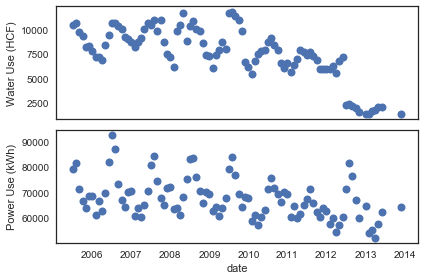

In [4]:
dfsum = dfv2.groupby('Date').sum()
dfsum.reset_index(inplace=True)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(dfsum['Date'], dfsum['Water Use'], marker='o', linestyle='', ms=8)
ax1.set_ylabel('Water Use (HCF)')

ax2.plot(dfsum['Date'], dfsum['Power Use'], marker='o', linestyle='', ms=8)
plt.xlabel('date')
ax2.set_ylabel('Power Use (kWh)')
plt.tight_layout()

# Data Cleaning

There is an extra point at the end that is separated from the rest of the dataset. I look specifically for times after Jan 1, 2013. I'm going to cut the water data off where the drop happens - there was an obvious change in policy or practice at that point.

In [5]:
dfsum[dfsum['Date'] > pd.Timestamp('2013-01-01')]

,Date,Water Use,Power Use,Zip
90,2013-02-01,1349.45,54265,13136208
91,2013-03-01,1640.86,55289,13136208
92,2013-04-01,1788.75,52367,13136208
93,2013-05-01,2037.96,57791,13136208
94,2013-06-01,2112.38,62299,13136208
95,2013-12-01,1398.03,64430,13136208


There are missing data points between July 2013 and November 2013. I cut the data off at June 30, 2013.

In [6]:
dfv3 = dfv2[dfv2['Date']<pd.Timestamp('2013-07-01')]
dfsum = dfv3.groupby('Date').sum()
dfsum.reset_index(inplace=True)

Before moving forward, it looks like there was a major change in water usage around the mid-point of 2012. However, when I look at the data grouped by zip code, I see that the drop is due to a change in the number of reported zip codes that happened in the middle of 2012. 

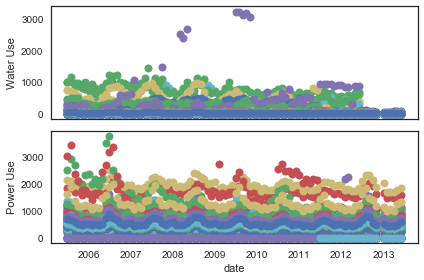

In [7]:
# Group data by zip code
groups = dfv3.groupby('Zip')

# Plot
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
for name, group in groups:
    ax1.plot(group['Date'], group['Water Use'], marker='o', linestyle='', ms=8, label=name)
    #ax.set_aspect(1)
    #break
#ax.legend(bbox_to_anchor=(1,0.5))

ax1.set_ylabel('Water Use')


ax2.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
for name, group in groups:
    ax2.plot(group['Date'], group['Power Use'], marker='o', linestyle='', ms=8, label=name)
    #ax.set_aspect(1)
    #break
#ax.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('date')
ax2.set_ylabel('Power Use')
plt.tight_layout()

Because my fits will be by zip code, this should not be an issue. However, there are a handfull of possible outliers in the water use data.

# Outlier Detection

I utilize the Mahalanobis distance to see how far from the average of the data the potential outliers are.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


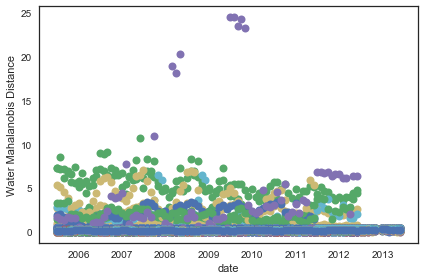

In [10]:
# Measure the mahalanobis distance.
X=dfv3[['Water Use']].values
emp_cov = EmpiricalCovariance().fit(X)
mahal_dist = np.sqrt(emp_cov.mahalanobis(X))
dfv3["M_dist"] = mahal_dist

groups = dfv3.groupby('Zip')
plt.figure()
ax2 = plt.gca()
ax2.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
for name, group in groups:
    ax2.plot(group['Date'], group['M_dist'], marker='o', linestyle='', ms=8, label=name)
    #ax.set_aspect(1)
    #break
#ax.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('date')
ax2.set_ylabel('Water Mahalanobis Distance')
plt.tight_layout()

In [11]:
dfv4 = dfv3.reset_index(drop=True)
dfv4.head(2)

,Water Use,Power Use,Date,Zip,M_dist
0,16.70,396,2008-03-01,90230,0.277616
1,35.73,1013,2011-07-01,90272,0.131137


# Data Enrichment

There is a definite month/year periodicity in the data. I add month and year data features to the model. I visualize the data to and see that the periodicity is clearly visible in both the water use and the power use data.

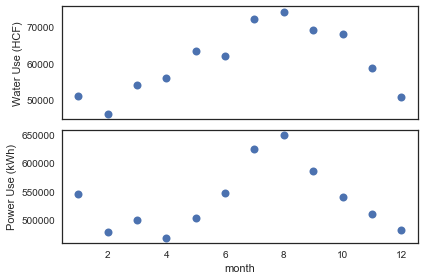

In [12]:
dfv4['Month'] = dfv4['Date'].apply(lambda x: x.month)
dfv4['Year'] = dfv4['Date'].apply(lambda x: x.year)

dfsum = dfv4.groupby('Month').sum()
dfsum.reset_index(inplace=True)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(dfsum['Month'], dfsum['Water Use'], marker='o', linestyle='', ms=8)
ax1.set_ylabel('Water Use (HCF)')

ax2.plot(dfsum['Month'], dfsum['Power Use'], marker='o', linestyle='', ms=8)
plt.xlabel('month')
ax2.set_ylabel('Power Use (kWh)')
plt.tight_layout()

Both the water and the power usage go up in the summer months, which makes sense. There is also a power spike in January that may be related to heating on cold days.

## Enriching Data with other Datasets

I hypothesize that the water and power useage depends on the following additional factors:
1) Population of each zip code
2) Economic status of each zip code (weath distribution)
3) Weather data

I join the original dataset with three additonal datasets to add these features.


### Adding Population Data

The population data was retrieved from the US Census Bureau.
> https://www.census.gov/geo/maps-data/data/zcta_rel_download.html

The dataset includes information about the population, the land area, and the total area for each zip code. There are a number of other columns of data that I will not use. I convert the zip code column (ZCTA5) to an integer in order to match the datatype of my power/water usage dataframe zip code.

In [13]:
dfzip = pd.read_csv("../data/zcta_county_rel_10.txt",dtype={'ZCTA5':'object'})
dfzip['ZCTA5'] = dfzip['ZCTA5'].astype(int)
dfzip.head(2)

,ZCTA5,STATE,COUNTY,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,...,COAREA,COAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,COPOPPCT,COHUPCT,COAREAPCT,COAREALANDPCT
0,601,72,1,72001,18465,7695,165132671,164333375,18570,7744,...,173777444,172725651,99.43,99.37,98.61,98.6,94.77,94.71,95.03,95.14
1,601,72,141,72141,105,49,2326414,2326414,18570,7744,...,298027589,294039825,0.57,0.63,1.39,1.4,0.32,0.35,0.78,0.79


Because the data in this set are intended to merge other datasets, there are multiple entries for each zip code. The "Z" columns are totals for each zip code, so I only need one of them - I use the `max` aggregation. I  cut the unneeded columns, keeping only the zip code, population, total area, and land area columns. 

In [14]:
dfzipgroups = (dfzip[['ZCTA5','ZPOP','ZAREA','ZAREALAND']].groupby("ZCTA5").max())
dfzipgroups.reset_index(inplace=True)
dfzipgroups.head(2)

,ZCTA5,ZPOP,ZAREA,ZAREALAND
0,601,18570,167459085,166659789
1,602,41520,83734431,79288158


To get a sense of the dataset, I look at the relationship between the land area and the population.

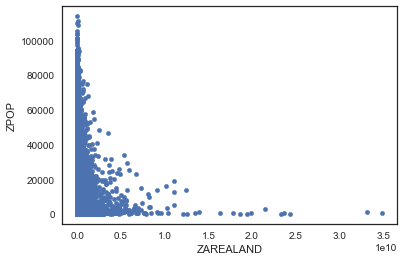

In [15]:
dfzipgroups.plot.scatter(x='ZAREALAND',y='ZPOP')

There is an interesting anti-correlation here. But perhaps that isn't too surprising, as larger population densities will have more zip codes associated with them, so most of the data would be in small land area, large populations.

Now I merge this will the resource use database, keeping only the columns that I need after the join. 

In [16]:
dfv5 = pd.merge(dfv4,dfzipgroups,left_on="Zip",right_on="ZCTA5")
print("{} rows lost in data merge.".format(len(dfv4.index)-len(dfv5.index)))
dfv5.drop(['ZCTA5'],axis=1,inplace=True)
dfv5.head(2)

950 rows lost in data merge.


,Water Use,Power Use,Date,Zip,M_dist,Month,Year,ZPOP,ZAREA,ZAREALAND
0,16.70,396,2008-03-01,90230,0.277616,3,2008,31766,11785759,11672688
1,17.59,407,2005-12-01,90230,0.270766,12,2005,31766,11785759,11672688


There were a number of rows lost in the merge- these were zip codes that were not in the US Census database.

I graph the new inputs to see how the Water and Power use depend on them.

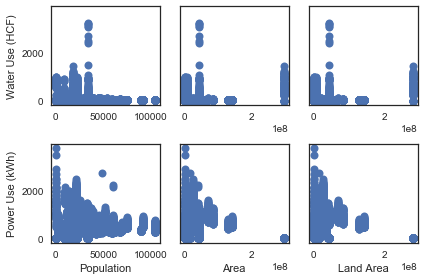

In [17]:
f, (ax1, ax2) = plt.subplots(2, 3, sharey=True)
ax1[0].plot(dfv5['ZPOP'], dfv5['Water Use'], marker='o', linestyle='', ms=8)
ax1[0].set_ylabel('Water Use (HCF)')
ax2[0].plot(dfv5['ZPOP'], dfv5['Power Use'], marker='o', linestyle='', ms=8)
ax2[0].set_ylabel('Power Use (kWh)')
ax2[0].set_xlabel('Population')

ax1[1].plot(dfv5['ZAREA'], dfv5['Water Use'], marker='o', linestyle='', ms=8)
ax2[1].plot(dfv5['ZAREA'], dfv5['Power Use'], marker='o', linestyle='', ms=8)
ax2[1].set_xlabel('Area')

ax1[2].plot(dfv5['ZAREALAND'], dfv5['Water Use'], marker='o', linestyle='', ms=8)
ax2[2].plot(dfv5['ZAREALAND'], dfv5['Power Use'], marker='o', linestyle='', ms=8)
ax2[2].set_xlabel('Land Area')

plt.tight_layout()


It looks like the power use is more strongly correlation with the census and land area data.

### Adding Economic Data

I add the economic data which is based on IRS tax records:
> https://www.irs.gov/uac/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi

This dataset has the following variables I am interested in:
* Nreturns: number of filed tax returns
* AGI: adjusted gross income (in thousands of \$)
* SW: Salary and Wages (in thousands of \$)
* EIC: total earned income tax credit (in thousands of \$)

However, the dataset is originally an Excel spreadsheet with multiple sheet names. I created a short function to retrieve the tax data I want.

In [18]:
def getTaxYear(year):
    # This function reads in a single sheet from the Excel document, then returns it as a dataframe.
    dftemp = pd.read_excel("../data/allCAtaxdata2005-2013.xlsx",sheetname='{}'.format(year),thousands=",",na_values=["*","*              ",".","-"])
    dftemp['Zip Code'] = dftemp['Zip Code'].astype('int')
    dftemp['Year'] = year
    return dftemp

dftaxes = pd.concat([getTaxYear(x) for x in range(2005,2014)])
# Drop NaNs from data
dftaxes.dropna(inplace=True)

dftaxes.head(2)

,Zip Code,Nreturns,AGI,SW,EIC,Year
0,90001,17313,406784,358687.0,16162.0,2005
1,90002,14712,331533,294916.0,16130.0,2005


I visualize the economic data in the following plot.

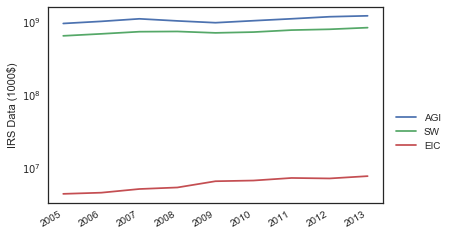

In [19]:
dfgroup = dftaxes.groupby('Year').sum()
dfgroup.reset_index(inplace=True)

plt.plot(dfgroup['Year'],dfgroup['AGI'],label='AGI')
plt.plot(dfgroup['Year'],dfgroup['SW'],label='SW')
plt.plot(dfgroup['Year'],dfgroup['EIC'],label='EIC')
plt.legend(bbox_to_anchor=(1.2,0.5))
plt.gca().set_yscale('log')
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.gcf().autofmt_xdate()
plt.ylabel('IRS Data (1000$)')

I merge the IRS dataset with the population and usage dataset.

In [20]:
dfv6 = pd.merge(dfv5,dftaxes,how="inner",left_on=["Zip","Year"],right_on=["Zip Code","Year"])
print("{} rows lost in data merge.".format(len(dfv5.index)-len(dfv6.index)))
dfv6.drop('Zip Code',axis=1,inplace=True)
dfv6.head(2)

190 rows lost in data merge.


,Water Use,Power Use,Date,Zip,M_dist,Month,Year,ZPOP,ZAREA,ZAREALAND,Nreturns,AGI,SW,EIC
0,16.70,396,2008-03-01,90230,0.277616,3,2008,31766,11785759,11672688,15572,1008925,765127.0,3537.0
1,20.95,368,2008-07-01,90230,0.244903,7,2008,31766,11785759,11672688,15572,1008925,765127.0,3537.0


There is an additional data loss in this merge. However, I still have most of my original dataset.

In [21]:
print("Remaining data (from original dataset): {0:.1f}%".format(float(len(dfv6.index))/(len(dfv1.index))*100))

Remaining data (from original dataset): 90.8%


I visualize the combined dataset.

(0, 46370.0)

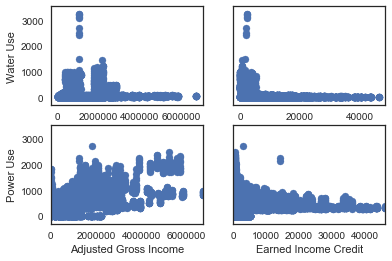

In [22]:
# Plot usage vs Adjusted Gross Income
f, (ax1, ax2) = plt.subplots(2, 2, sharey=True)

ax1[0].scatter(dfv6['AGI'],dfv6['Water Use'])
ax1[0].set_ylabel("Water Use")

ax2[0].scatter(dfv6['AGI'],dfv6['Power Use'])
ax2[0].set_ylabel("Power Use")
ax2[0].set_xlabel("Adjusted Gross Income")
ax2[0].set_xlim(0,max(dfv6['AGI']))

ax1[1].scatter(dfv6['EIC'],dfv6['Water Use'])
ax2[1].scatter(dfv6['EIC'],dfv6['Power Use'])
ax2[1].set_xlabel("Earned Income Credit")
ax2[1].set_xlim(0,max(dfv6['EIC']))

Again, there aren't strong correlations here, but the correlations that exist may improve the model. I am also interested in how closely this IRS dataset tracks the US Census dataset. The number of tax returns in a zip code should be close to the number of people living in that area. I plot the number of returns versus the census population to check this correlation.

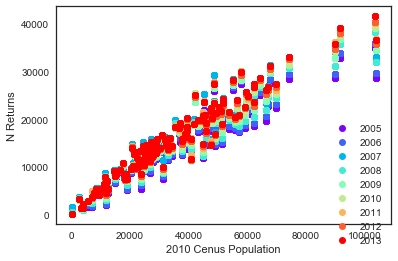

In [23]:
#We'll use a different tool to plot the data now that we know how to group the data by a category. This will help us make better combined plots later on.
groups = dfv6.groupby('Year')

# Plot
trainfig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(groups))))
for name, group in groups:
    ax.plot(group['ZPOP'],group['Nreturns'],'o',label=name,color=next(colors))
ax.legend(bbox_to_anchor=(1,0.5))
ax.set_ylabel('N Returns')
ax.set_xlabel('2010 Cenus Population')

The correlation is as expected. Howver, there is also a trend based on the year which probably corresponds to the growth and decline in populations.

### Adding Weather Data

I add historical weather data to my input features. This dataset comes from:

> https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GSOM

The dataset has the following variables:

* AWND: average wind speed (m/s)
* CLDD: cooling degree days
* HTDD: heating degree days
* PRCP: preciptiation (cm)
* TSUN: daily total sunshine
* TAVG: Average daily temperature (celsius) [Not Used]

The weather data is essentially the same for all of the zip codes in this dataset- they are all in the city of Los Angeles. Any small variation in the rain or temperature will be negligible because I only have the average over the full month of data.

In [24]:
weatherdf = pd.read_csv("../data/LAX_weather.csv",parse_dates=[2])
weatherdf.fillna(0.0, inplace=True)
weatherdf['Date']=pd.to_datetime(weatherdf['DATE'])
weatherdf.drop(['STATION', 'NAME','DATE'],axis=1, inplace=True)
weatherdf.head(2)

,AWND,CLDD,HTDD,PRCP,TAVG,TSUN,Date
0,3.2,4.8,135.2,174.5,14.1,0.0,2005-01-01
1,3.5,0.0,106.5,176.6,14.5,0.0,2005-02-01


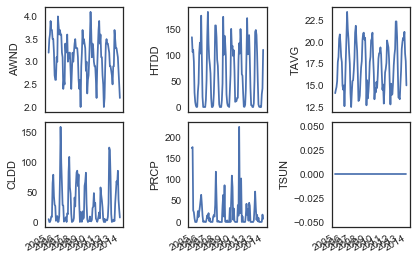

In [25]:

# Plot weather data
f, (ax1, ax2) = plt.subplots(2, 3, sharex=True)

ax1[0].plot(weatherdf['Date'],weatherdf['AWND'])
ax1[0].set_ylabel("AWND")
ax2[0].plot(weatherdf['Date'],weatherdf['CLDD'])
ax2[0].set_ylabel("CLDD")

ax1[1].plot(weatherdf['Date'],weatherdf['HTDD'])
ax1[1].set_ylabel("HTDD")
ax2[1].plot(weatherdf['Date'],weatherdf['PRCP'])
ax2[1].set_ylabel("PRCP")
ax1[2].plot(weatherdf['Date'],weatherdf['TAVG'])
ax1[2].set_ylabel("TAVG")
ax2[2].plot(weatherdf['Date'],weatherdf['TSUN'])
ax2[2].set_ylabel("TSUN")

plt.tight_layout()
plt.gcf().autofmt_xdate()


I merge this last dataset with my other features.

In [26]:
dfv7 = pd.merge(dfv6, weatherdf, on='Date')
print("{} rows lost in data merge.".format(len(dfv6.index)-len(dfv7.index)))
dfv7.drop(['TSUN'],axis=1,inplace=True)
dfv7.head(2)

0 rows lost in data merge.


,Water Use,Power Use,Date,Zip,M_dist,Month,Year,ZPOP,ZAREA,ZAREALAND,Nreturns,AGI,SW,EIC,AWND,CLDD,HTDD,PRCP,TAVG
0,16.70,396,2008-03-01,90230,0.277616,3,2008,31766,11785759,11672688,15572,1008925,765127.0,3537.0,3.2,6.7,91.5,0.8,15.6
1,30.18,970,2008-03-01,90272,0.173857,3,2008,22986,60557886,59133992,11165,3569670,1750980.0,355.0,3.2,6.7,91.5,0.8,15.6


There were weather data for all of the existing rows, so there wasn't any data lost in this step. I visualize the weather data and the water/power use data together to look for correlations.

(0, 224.19999999999999)

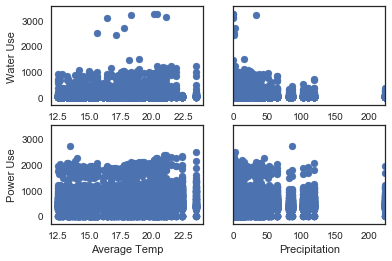

In [27]:
# Plot usage vs weather
f, (ax1, ax2) = plt.subplots(2, 2, sharey=True)

ax1[0].scatter(dfv7['TAVG'],dfv7['Water Use'])
ax1[0].set_ylabel("Water Use")

ax2[0].scatter(dfv7['TAVG'],dfv7['Power Use'])
ax2[0].set_ylabel("Power Use")
ax2[0].set_xlabel("Average Temp")


ax1[1].scatter(dfv7['PRCP'],dfv7['Water Use'])
ax1[1].set_xlim(0,max(dfv7['PRCP']))
ax2[1].scatter(dfv7['PRCP'],dfv7['Power Use'])
ax2[1].set_xlabel("Precipitation")
ax2[1].set_xlim(0,max(dfv7['PRCP']))

It certainly looks like there are correlations here - at least between the Water Use/Precepitation and the Power Use/Average Temp datasets.

In [28]:
dfv7.to_csv("../data/enriched_data.csv",index=False)